In [96]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


In [97]:
churn_data = pd.read_csv('churn.csv')

In [98]:
churn_data.columns = [col.title() for col in churn_data.columns]
churn_data.head()

,Customerid,Gender,Seniorcitizen,Partner,Dependents,Tenure,Phoneservice,Multiplelines,Internetservice,Onlinesecurity,...,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Contract,Paperlessbilling,Paymentmethod,Monthlycharges,Totalcharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [99]:
churn_data.dtypes

Customerid              str
Gender                  str
Seniorcitizen         int64
Partner                 str
Dependents              str
Tenure                int64
Phoneservice            str
Multiplelines           str
Internetservice         str
Onlinesecurity          str
Onlinebackup            str
Deviceprotection        str
Techsupport             str
Streamingtv             str
Streamingmovies         str
Contract                str
Paperlessbilling        str
Paymentmethod           str
Monthlycharges      float64
Totalcharges            str
Churn                   str
dtype: object

Our baseline is going to be randomly assigning a class - 0/1 for No churn/Churn respectively

I am selecting three models here - linear regression for its class probability estimations, knn as it based on distances and a tree based random forest model for its information gain with features. We can later make ensemble models combining them.

In [100]:
#reengineering some features to reduce the distance issues with some classification models.
churn_data['Tenure_in_yrs'] = churn_data['Tenure']//12
churn_data['Monthlycharges_100s'] = round(churn_data['Monthlycharges']/100,2)

#convert total charges to float and converting it to 1000's
churn_data['Totalcharges'] = pd.to_numeric(churn_data['Totalcharges'], errors='coerce').fillna(0)
churn_data['Totalcharges_1000s'] = round(churn_data['Totalcharges']/1000, 2)

#dropping the original columns and also customer id
churn_data.drop(columns = ['Tenure','Monthlycharges','Totalcharges','Customerid'],inplace = True)

#replace 'No Internet Service' and 'No Phone Service'  as No
churn_data = churn_data.replace({'No phone service':'No', 'No internet service':'No'})


In [101]:
def transform_categorical_data(df, cols, drop_first=True):
    
    # Convert columns to category type (optional but good practice)
    df[cols] = df[cols].astype('category')
    
    # Create dummy variables
    df = pd.get_dummies(df, columns=cols, drop_first=drop_first)
    
    return df

categorical_cols = [
    'Gender',
    'Partner',
    'Dependents',
    'Contract',
    'Internetservice',
    'Paymentmethod'
]

data_encoded = transform_categorical_data(churn_data, categorical_cols)
data_encoded.head()
data_encoded.columns


Index(['Seniorcitizen', 'Phoneservice', 'Multiplelines', 'Onlinesecurity',
       'Onlinebackup', 'Deviceprotection', 'Techsupport', 'Streamingtv',
       'Streamingmovies', 'Paperlessbilling', 'Churn', 'Tenure_in_yrs',
       'Monthlycharges_100s', 'Totalcharges_1000s', 'Gender_Male',
       'Partner_Yes', 'Dependents_Yes', 'Contract_One year',
       'Contract_Two year', 'Internetservice_Fiber optic',
       'Internetservice_No', 'Paymentmethod_Credit card (automatic)',
       'Paymentmethod_Electronic check', 'Paymentmethod_Mailed check'],
      dtype='str')

In [102]:
churn_data.columns

Index(['Gender', 'Seniorcitizen', 'Partner', 'Dependents', 'Phoneservice',
       'Multiplelines', 'Internetservice', 'Onlinesecurity', 'Onlinebackup',
       'Deviceprotection', 'Techsupport', 'Streamingtv', 'Streamingmovies',
       'Contract', 'Paperlessbilling', 'Paymentmethod', 'Churn',
       'Tenure_in_yrs', 'Monthlycharges_100s', 'Totalcharges_1000s'],
      dtype='str')

In [103]:
#taking all the columns except for the customer id
cat_cols = [col for col in churn_data.columns if (churn_data[col].dtype.name in ['object','category'])]

churn_data = transform_categorical_data(churn_data, cat_cols)
churn_data.head()

,Seniorcitizen,Phoneservice,Multiplelines,Onlinesecurity,Onlinebackup,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Paperlessbilling,...,Gender_Male,Partner_Yes,Dependents_Yes,Internetservice_Fiber optic,Internetservice_No,Contract_One year,Contract_Two year,Paymentmethod_Credit card (automatic),Paymentmethod_Electronic check,Paymentmethod_Mailed check
0,0,No,No,No,Yes,No,No,No,No,Yes,...,False,True,False,False,False,False,False,False,True,False
1,0,Yes,No,Yes,No,Yes,No,No,No,No,...,True,False,False,False,False,True,False,False,False,True
2,0,Yes,No,Yes,Yes,No,No,No,No,Yes,...,True,False,False,False,False,False,False,False,False,True
3,0,No,No,Yes,No,Yes,Yes,No,No,No,...,True,False,False,False,False,True,False,False,False,False
4,0,Yes,No,No,No,No,No,No,No,Yes,...,False,False,False,True,False,False,False,False,True,False


In [104]:
churn_data['Partner_Yes']

0        True
1       False
2       False
3       False
4       False
        ...  
7038     True
7039     True
7040     True
7041     True
7042    False
Name: Partner_Yes, Length: 7043, dtype: bool

In [105]:
churn_data.columns

Index(['Seniorcitizen', 'Phoneservice', 'Multiplelines', 'Onlinesecurity',
       'Onlinebackup', 'Deviceprotection', 'Techsupport', 'Streamingtv',
       'Streamingmovies', 'Paperlessbilling', 'Churn', 'Tenure_in_yrs',
       'Monthlycharges_100s', 'Totalcharges_1000s', 'Gender_Male',
       'Partner_Yes', 'Dependents_Yes', 'Internetservice_Fiber optic',
       'Internetservice_No', 'Contract_One year', 'Contract_Two year',
       'Paymentmethod_Credit card (automatic)',
       'Paymentmethod_Electronic check', 'Paymentmethod_Mailed check'],
      dtype='str')

In [106]:
churn_data.dtypes

Seniorcitizen                              int64
Phoneservice                                 str
Multiplelines                                str
Onlinesecurity                               str
Onlinebackup                                 str
Deviceprotection                             str
Techsupport                                  str
Streamingtv                                  str
Streamingmovies                              str
Paperlessbilling                             str
Churn                                        str
Tenure_in_yrs                              int64
Monthlycharges_100s                      float64
Totalcharges_1000s                       float64
Gender_Male                                 bool
Partner_Yes                                 bool
Dependents_Yes                              bool
Internetservice_Fiber optic                 bool
Internetservice_No                          bool
Contract_One year                           bool
Contract_Two year   

In [107]:
#creating a new feature family that captures if a customer has a partner or dependents (children or parents)
churn_data['Family'] = np.where((churn_data['Partner_Yes'] == 1) |(churn_data['Dependents_Yes'] == 1),1,0)
churn_data.drop(columns=['Partner_Yes','Dependents_Yes'],inplace=True)

In [108]:
churn_data['Churn']=churn_data['Churn'].map({'No': 0, 'Yes': 1})

In [109]:
X = churn_data.drop(columns=['Churn', 'Totalcharges_1000s'])
Y = churn_data['Churn']

In [114]:
def baseline_pred(X, y_true):
    
    # random 0 or 1 predictions
    y_pred = np.random.randint(0, 2, size=X.shape[0])
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    accuracy = round((tp + tn) / X.shape[0], 3)
    
    print("Baseline accuracy:", accuracy)

In [115]:
baseline_pred(X, Y)

Baseline accuracy: 0.498


In [121]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)


model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)



def classification_metrics(y_true, y_pred, y_prob):
    
    # Accuracy
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    balanced_acc = round(balanced_accuracy_score(y_true, y_pred), 3)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    sensitivity = round(tp / (tp + fn), 3)   # Recall for churn
    specificity = round(tn / (tn + fp), 3)
    
    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = round(auc(fpr, tpr), 3)
    
    print("Accuracy:", accuracy)
    print("Balanced Accuracy:", balanced_acc)
    print("Sensitivity (Recall):", sensitivity)
    print("Specificity:", specificity)
    print("AUC:", auc_score)
    
    # Plot ROC curve
    plt.plot(fpr, tpr)
    plt.fill_between(fpr, tpr, alpha=0.3)
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()



In [122]:
print(X.dtypes)


Seniorcitizen                              int64
Tenure_in_yrs                              int64
Monthlycharges_100s                      float64
Gender_Male                                 bool
Internetservice_Fiber optic                 bool
Internetservice_No                          bool
Contract_One year                           bool
Contract_Two year                           bool
Paymentmethod_Credit card (automatic)       bool
Paymentmethod_Electronic check              bool
Paymentmethod_Mailed check                  bool
Family                                     int64
Phoneservice_Yes                            bool
Multiplelines_Yes                           bool
Onlinesecurity_Yes                          bool
Onlinebackup_Yes                            bool
Deviceprotection_Yes                        bool
Techsupport_Yes                             bool
Streamingtv_Yes                             bool
Streamingmovies_Yes                         bool
Paperlessbilling_Yes

model is logistic regression
Accuracy: 0.809
Balanced Accuracy: 0.732
Sensitivity (Recall): 0.563
Specificity: 0.901
AUC: 0.853


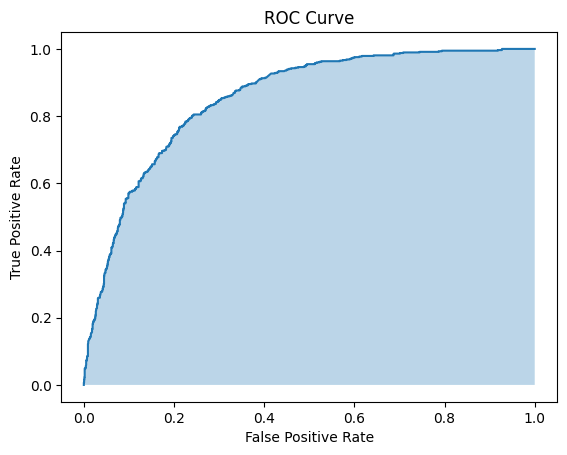

In [152]:
print("model is logistic regression")
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

classification_metrics(y_test, y_pred, y_prob)


In [124]:
from sklearn.model_selection import train_test_split

def train_and_evaluate(X, Y, model, test_size=0.3, random_state=42):
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, random_state=random_state
    )
    
    # Fit
    model.fit(X_train, y_train)
    
    # Scores
    print("Train Accuracy:", round(model.score(X_train, y_train), 3))
    print("Test Accuracy:", round(model.score(X_test, y_test), 3))
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Check if model supports probability
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = None
    
    # Metrics
    if y_prob is not None:
        classification_metrics(y_test, y_pred, y_prob)
    else:
        print("Model does not support probability prediction.")
    
    return model


Train Accuracy: 0.801
Test Accuracy: 0.809
Accuracy: 0.809
Balanced Accuracy: 0.732
Sensitivity (Recall): 0.563
Specificity: 0.901
AUC: 0.853


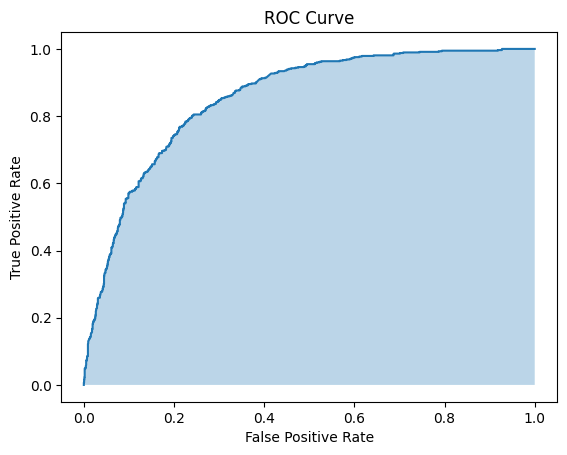

In [125]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)

trained_model = train_and_evaluate(X, Y, model)


Train Accuracy: 0.8
Test Accuracy: 0.809
Accuracy: 0.809
Balanced Accuracy: 0.731
Sensitivity (Recall): 0.561
Specificity: 0.901
AUC: 0.853


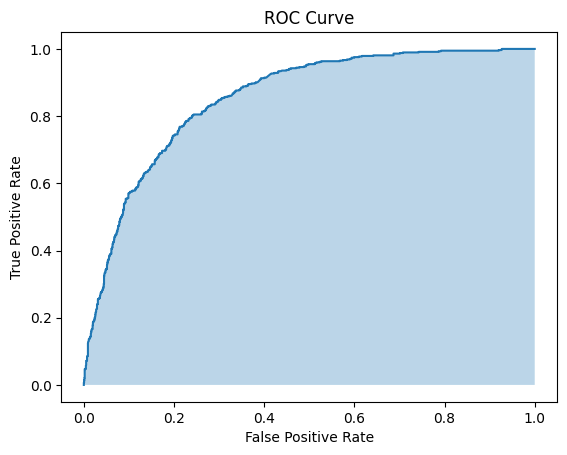

In [127]:
logit = LogisticRegression(solver='liblinear', max_iter=1000)

trained_model = train_and_evaluate(X, Y, logit)


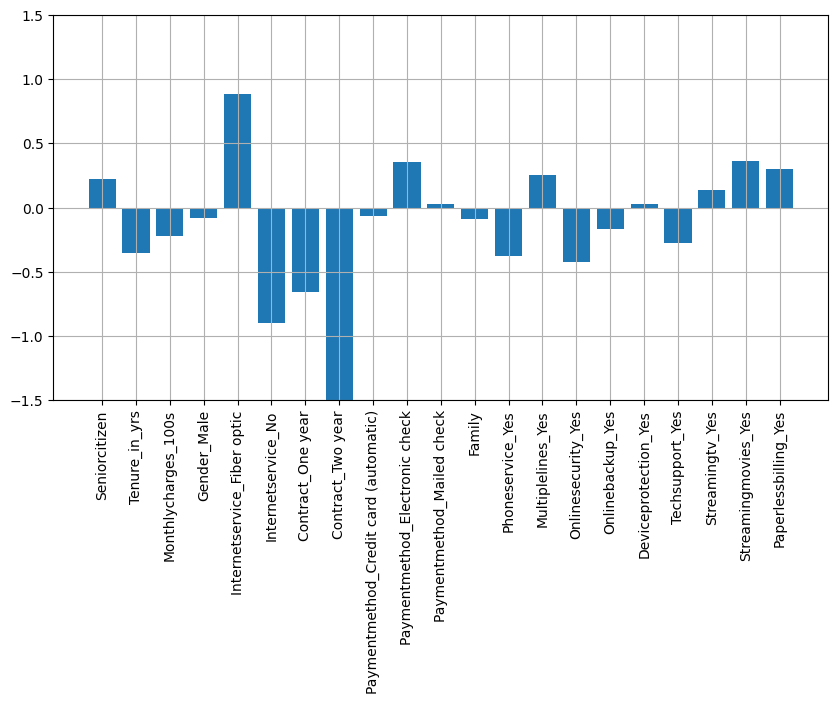

In [128]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(x = X.columns, height=logit.coef_[0])
plt.xticks(rotation=90)
plt.ylim(-1.5,1.5)
plt.grid()
plt.show()

Train Accuracy: 0.97
Test Accuracy: 0.761
Accuracy: 0.761
Balanced Accuracy: 0.674
Sensitivity (Recall): 0.484
Specificity: 0.864
AUC: 0.763


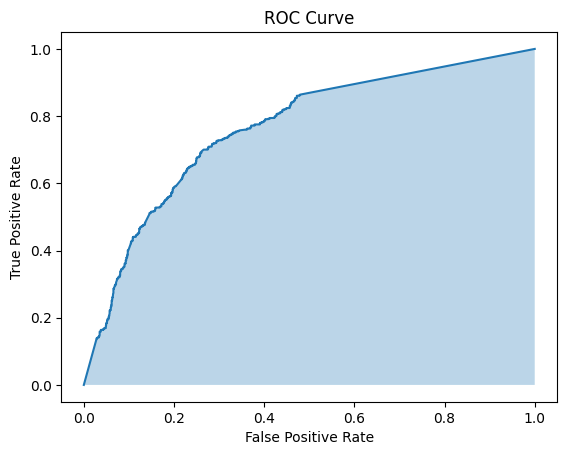

In [130]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(weights='distance')

trained_knn = train_and_evaluate(X, Y, knn_model)


Train Accuracy: 0.97
Test Accuracy: 0.774
Accuracy: 0.774
Balanced Accuracy: 0.678
Sensitivity (Recall): 0.467
Specificity: 0.889
AUC: 0.811


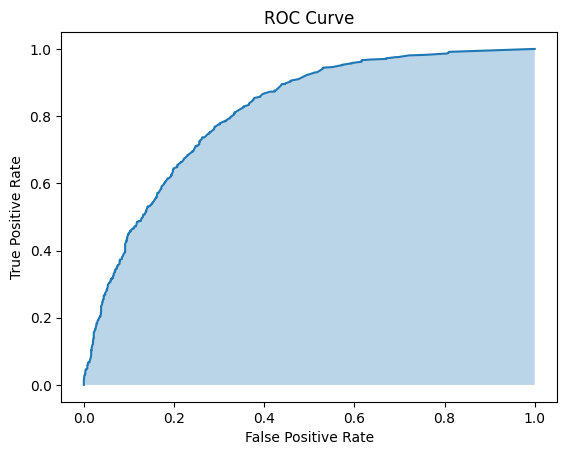

In [131]:
from sklearn.ensemble import RandomForestClassifier

rnd_forest = RandomForestClassifier(n_estimators=100, random_state=42)

trained_rf = train_and_evaluate(X, Y, rnd_forest)


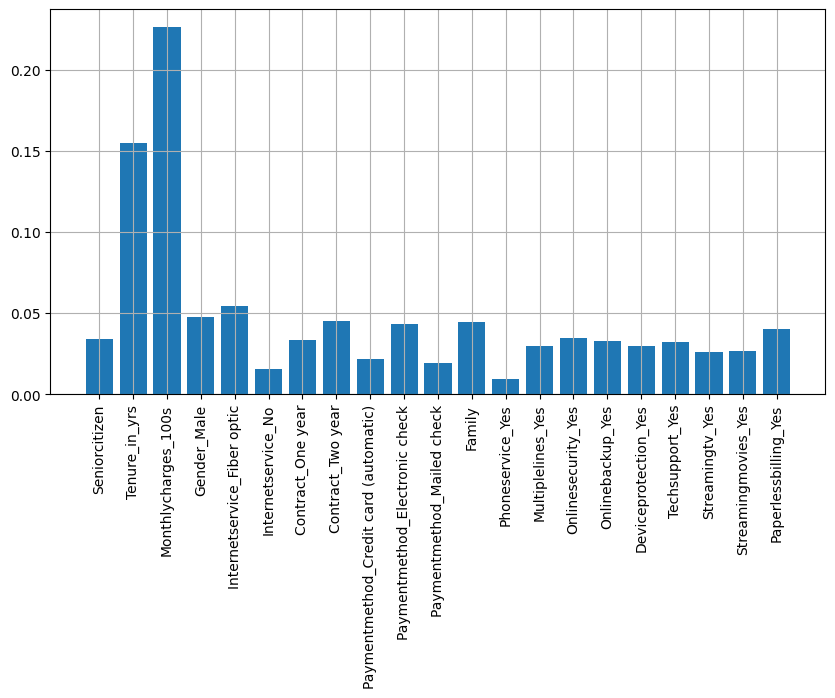

In [132]:
plt.figure(figsize=(10,5))
plt.bar(x = X.columns, height=rnd_forest.feature_importances_)
plt.xticks(rotation=90)
plt.grid()
plt.show()


In [133]:
#lets try voting classifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

vclf = VotingClassifier(estimators=[('lr',logit),('knn',knn_model),('rf',rnd_forest)], voting='hard')
for clf, label in zip([logit, knn_model, rnd_forest, vclf], ['Logistic reg','KNN classification','Random forest','Voting ensemble']):
    scores = cross_val_score(clf, X, Y, scoring ='accuracy', cv=5)
    print('Accuracy : %0.3f (+/- %0.2f) [%s]'%(scores.mean(), scores.std(), label))


Accuracy : 0.798 (+/- 0.01) [Logistic reg]
Accuracy : 0.760 (+/- 0.01) [KNN classification]
Accuracy : 0.772 (+/- 0.01) [Random forest]
Accuracy : 0.776 (+/- 0.01) [Voting ensemble]


Balanced accuracy is around 10% lesser than actual accuracy. This could be an indication of unbalanced classes. Can try to do some sampling techniques to see if it improves the prediction. 

Logistic regression, performs better. The accuracy is better than any of the models, and even its performence (auc)is better than other models. 

In [135]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100]
}

# Logistic model (liblinear supports l1 + l2)
logit = LogisticRegression(
    solver='liblinear',
    max_iter=1000
)

# Grid search
grid = GridSearchCV(
    estimator=logit,
    param_grid=param_grid,
    scoring='roc_auc',   # better metric for churn
    cv=5,
    n_jobs=-1
)

grid.fit(X, Y)

print("Best Parameters:", grid.best_params_)
print("Best AUC:", round(grid.best_score_, 3))


Best Parameters: {'C': 1, 'penalty': 'l1'}
Best AUC: 0.841


C:\Users\Manis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


In [137]:
grid.best_params_

{'C': 1, 'penalty': 'l1'}

In [138]:
grid.best_estimator_

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l1'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multiclass` p

In [139]:
grid.best_score_

np.float64(0.8408468527865216)

In [140]:
grid.scorer_

make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba'))

In [141]:
grid_scores = cross_val_score(grid.best_estimator_, X, Y, scoring = 'accuracy', cv = 5)
print('Accuracy = %0.3f(+/- %0.2f)'%(grid_scores.mean(), grid_scores.std()))

Accuracy = 0.798(+/- 0.01)


C:\Users\Manis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
C:\Users\Manis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
C:\Users\Manis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
C:\Users\Manis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.1

In [142]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150, 200]
}

rf = RandomForestClassifier(random_state=42)

grid = GridSearchCV(
    rf,
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid.fit(X, Y)

print("Best n_estimators:", grid.best_params_)
print("Best AUC:", round(grid.best_score_, 3))


Best n_estimators: {'n_estimators': 200}
Best AUC: 0.802


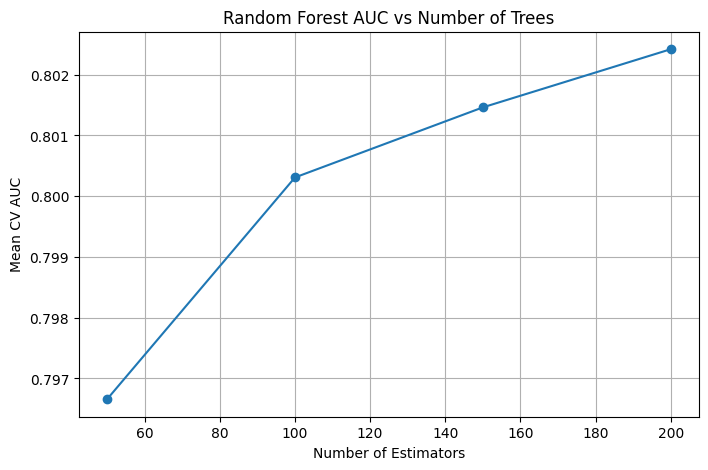

In [144]:
results = pd.DataFrame(grid.cv_results_)

plt.figure(figsize=(8,5))
plt.plot(results['param_n_estimators'], results['mean_test_score'], marker='o')

plt.xlabel("Number of Estimators")
plt.ylabel("Mean CV AUC")
plt.title("Random Forest AUC vs Number of Trees")
plt.grid(True)
plt.show()


The performance is better for the classifier between 80 - 100 estimators. 

   depth  train_accuracy  test_accuracy
0      1        0.737323       0.728348
1      2        0.756187       0.752485
2      3        0.784787       0.777567
3      4        0.787830       0.780880
4      5        0.793509       0.785613
5     10        0.853955       0.796498
6     15        0.964300       0.785613
7     20        0.969980       0.774255
8     50        0.969980       0.774255
9    100        0.969980       0.774255


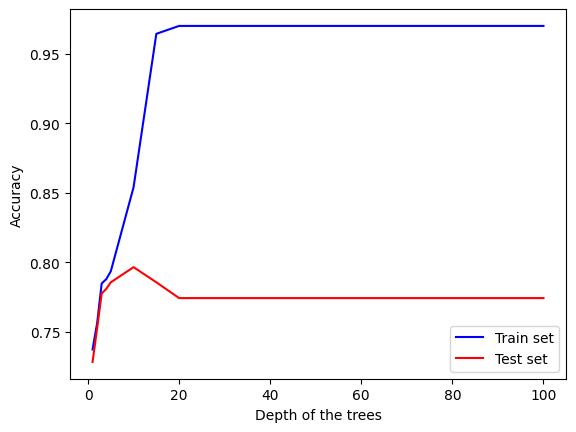

In [145]:
#hypertuning depth of the rnd forest classifier
# Depth effects the complexity of each tree. In order to balance bias vs trade-off compare with different depths.
from pandas import DataFrame

from warnings import simplefilter
simplefilter(action = 'ignore', category = FutureWarning)

depth_list = [1,2,3,4,5,10,15,20,50,100]
test_results = []
train_results = []

for depth in depth_list:
    model2 = RandomForestClassifier(max_depth=depth, random_state= 42)
    model2.fit(X_train,y_train)
    train_results.append(model2.score(X_train, y_train))
    test_results.append(model2.score(X_test, y_test))
    
print(DataFrame({'depth':depth_list, 'train_accuracy':train_results, 'test_accuracy':test_results}))    

plt.plot(depth_list, train_results, 'b', label='Train set')
plt.plot(depth_list, test_results, 'r', label = 'Test set')
plt.xlabel('Depth of the trees')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

At a depth of 5 levels test accuracy is max at 80.3% while training accuracy is only 79.5% . 
However at a depth of 10 levels test accuracy is significantly changed but training accuracy improved to 86%.

We can perform a grid search between 5 - 10 levels along with other hyper tuned parameters. 

  feat size  train_accuracy  test_accuracy
0      sqrt         0.96998       0.774255
1      log2         0.96998       0.774255
2       1.0         0.96998       0.769522
3       0.7         0.96998       0.773308
4       0.5         0.96998       0.770942
5       0.3         0.96998       0.774728
6       0.1         0.96998       0.778514


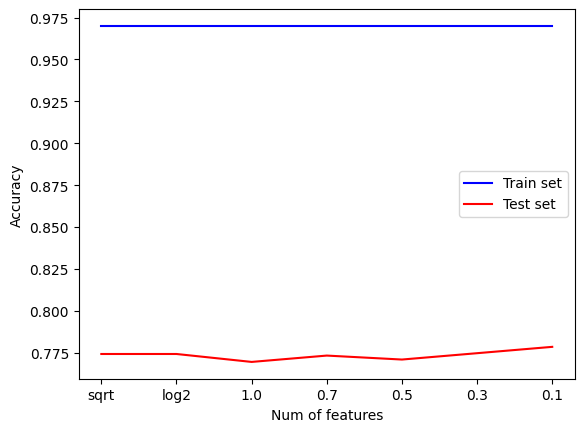

In [146]:
#Max features indicates the no . of features to consider for each split.
#More features indicates more levels of split to have a better entropy. 

max_features_list = ['sqrt', 'log2', 1.0, 0.7, 0.5, 0.3, 0.1]

test_results = []
train_results = []

for feat_size in max_features_list:
    model2 = RandomForestClassifier(max_features = feat_size, random_state= 42)
    model2.fit(X_train,y_train)
    train_results.append(model2.score(X_train, y_train))
    test_results.append(model2.score(X_test, y_test))
    
print(DataFrame({'feat size':max_features_list, 'train_accuracy':train_results, 'test_accuracy':test_results})) 

plt.plot(max_features_list, train_results, 'b', label='Train set')
plt.plot(max_features_list, test_results, 'r', label = 'Test set')
plt.xlabel('Num of features')
plt.ylabel('Accuracy')
plt.legend()
plt.show()    

With 0.3% features the accuracy if better. That is between 6 - 7 features. (0.3 * 21)

In [147]:
#lets try gridsearch with these values 

from sklearn.model_selection import GridSearchCV
from warnings import simplefilter

simplefilter(action='ignore', category = FutureWarning)

parameters = {'n_estimators':[80,100], 'max_depth':[5,7,10], 'max_features':[6,7]}

#defining the grid classifier estimator
rnd_forest = RandomForestClassifier()
rnd_forest_GridCV = GridSearchCV(rnd_forest, parameters, scoring=['accuracy', 'roc_auc'], refit = 'accuracy', cv = 5 )

#fitting the data on the model estimator
rnd_forest_GridCV.fit(X,Y)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestClassifier()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [5, 7, ...], 'max_features': [6, 7], 'n_estimators': [80, 100]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","['accuracy', 'roc_auc']"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'accuracy'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed

In [148]:
rnd_forest_GridCV.best_score_

np.float64(0.7989505371314278)

Train Accuracy: 0.815
Test Accuracy: 0.798
Accuracy: 0.798
Balanced Accuracy: 0.694
Sensitivity (Recall): 0.467
Specificity: 0.921
AUC: 0.853


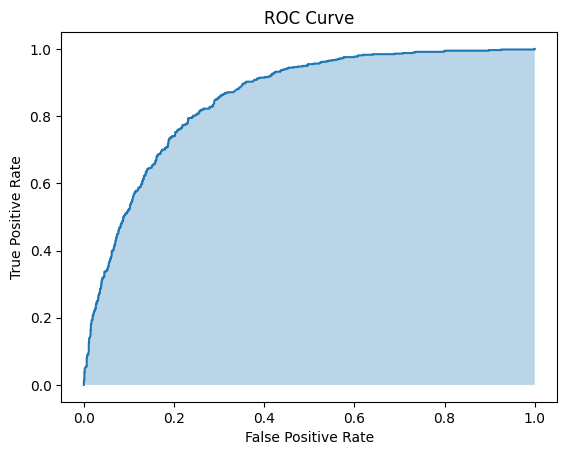

In [151]:
best_rf = rnd_forest_GridCV.best_estimator_

trained_rf = train_and_evaluate(X, Y, best_rf)


Using the best random forest classifier, acheived me an 80.4% accuracy as compared to logistic regression (79.7%) but the performance of both the models (auc score) is same. 

Although Random forest gives better variance with further information in Data like amount of data used with phone service, bandwidth subscriptions with internet service etc a Random forest model can be leverage better against the complexity.

With the current data Logistic regression can be considered to make for simple and understandable model. 